In [1]:
# Add directory above current directory to path
import sys as SYS; SYS.path.insert(0, '..')

# for saving
import os

from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt

from src import setup
# setup.use_gpu()

In [2]:
from src import ( 
    measurements as measure,
    ket as ket,
    density_matrix as DM,
    simulation as sim,
    orders,
    order_rules,
    random_unitary,
    simulation)

from Scripts import simulation_CLI as cleo

In [3]:
import numpy as np
from functools import reduce

# Define the Pauli matrices
pauli_matrices = {
    0: np.eye(2),  # Identity matrix
    1: np.array([[0, 1], [1, 0]]),  # Pauli-X
    2: np.array([[0, -1j], [1j, 0]]),  # Pauli-Y
    3: np.array([[1, 0], [0, -1]])  # Pauli-Z
}

# Define the adjacency matrix (Hamiltonian for network adjacency matrix)
HamiltonianforNetworkAdjacencyMatrix = np.array([[0.  , 0.02, 0.01, 0.01, 0.01, 0.02, 0.  , 0.91, 0.  , 0.01],
       [0.02, 0.  , 0.  , 0.04, 0.01, 0.01, 0.91, 0.  , 0.  , 0.  ],
       [0.01, 0.  , 0.  , 0.01, 0.02, 0.  , 0.02, 0.01, 0.92, 0.  ],
       [0.01, 0.04, 0.01, 0.  , 0.  , 0.92, 0.  , 0.  , 0.01, 0.  ],
       [0.01, 0.01, 0.02, 0.  , 0.  , 0.01, 0.  , 0.  , 0.01, 0.93],
       [0.02, 0.01, 0.  , 0.92, 0.01, 0.  , 0.01, 0.02, 0.  , 0.  ],
       [0.  , 0.91, 0.02, 0.  , 0.  , 0.01, 0.  , 0.  , 0.02, 0.03],
       [0.91, 0.  , 0.01, 0.  , 0.  , 0.02, 0.  , 0.  , 0.03, 0.02],
       [0.  , 0.  , 0.92, 0.01, 0.01, 0.  , 0.02, 0.03, 0.  , 0.  ],
       [0.01, 0.  , 0.  , 0.  , 0.93, 0.  , 0.03, 0.02, 0.  , 0.  ]])

# Function to create Kronecker product of Pauli matrices for 10 qubits
def ten_string_operator(indices):
    operators = [pauli_matrices[idx] for idx in indices]
    return reduce(np.kron, operators)

# Calculate the system Hamiltonian
SysHam = np.zeros((2**10, 2**10), dtype=complex)  # Initialize a 2^10 x 2^10 matrix

# Iterate over the adjacency matrix
num_qubits = 10
for i in range(num_qubits):
    for j in range(i + 1, num_qubits):
        if HamiltonianforNetworkAdjacencyMatrix[i, j] != 0:
            # Create the term for TenStringOperator with Pauli X and Y
            term_ij = (ten_string_operator([1 if k == i else 2 if k == j else 0 for k in range(num_qubits)]) -
                       ten_string_operator([2 if k == i else 1 if k == j else 0 for k in range(num_qubits)]))
            # Add to the system Hamiltonian
            SysHam += HamiltonianforNetworkAdjacencyMatrix[i, j] * term_ij

print("System Hamiltonian shape:", SysHam.shape)


System Hamiltonian shape: (1024, 1024)


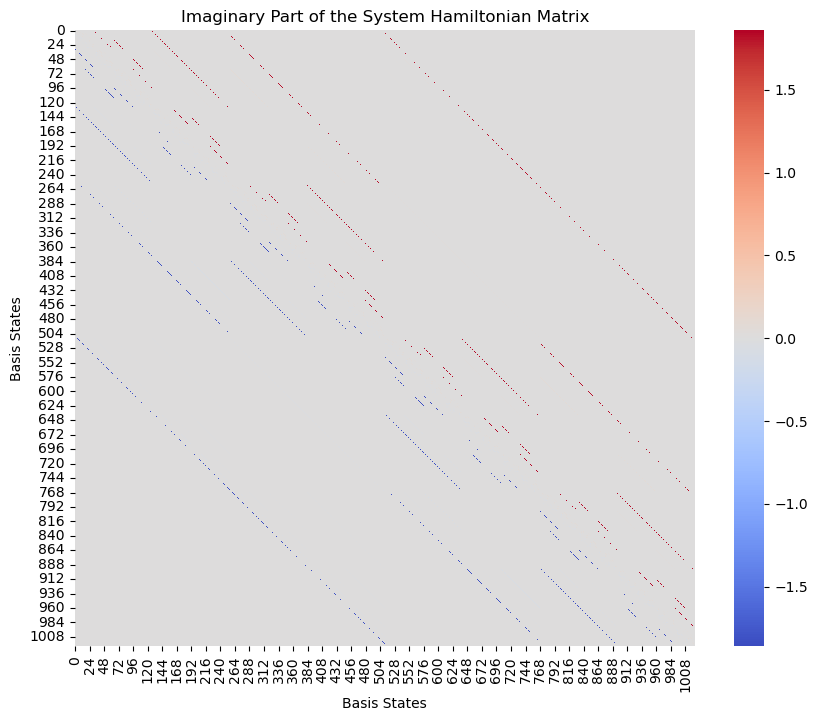

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming SysHam is the Hamiltonian matrix from your previous calculation

# Create a matrix plot (heatmap) of the imaginary part of the system Hamiltonian
plt.figure(figsize=(10, 8))
sns.heatmap(np.imag(SysHam), cmap='coolwarm', cbar=True)

# Add labels and title
plt.title('Imaginary Part of the System Hamiltonian Matrix')
plt.xlabel('Basis States')
plt.ylabel('Basis States')

# Show the plot
plt.show()



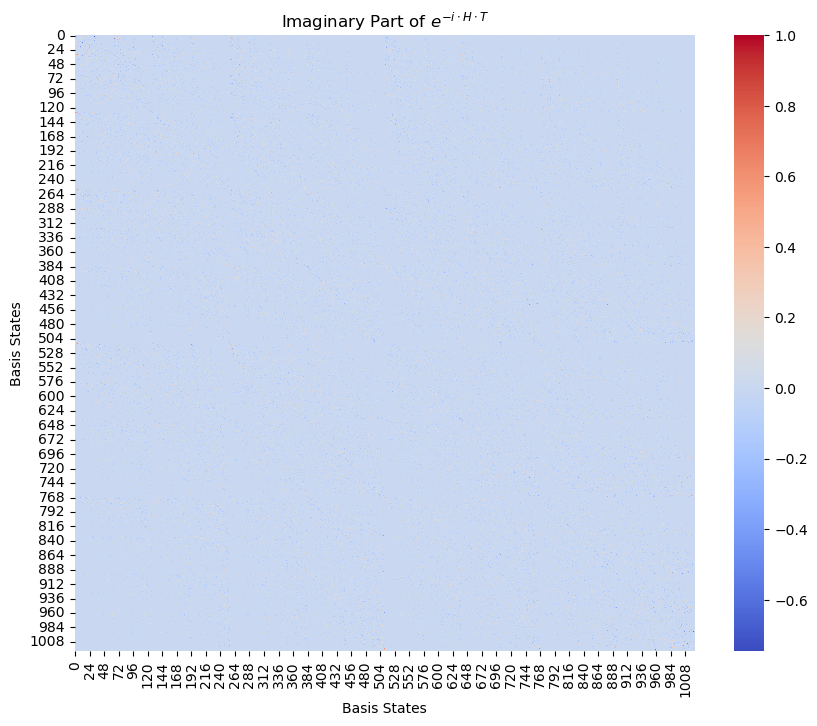

In [5]:
import numpy as np
from scipy.linalg import expm
import matplotlib.pyplot as plt
import seaborn as sns

# Define T (time)
T = 100.0  # Example time value, can be any value

# Construct the matrix exponential of -i * SysHam * T
exp_Ham = expm(-1j * SysHam * T)

# Plot only the imaginary parts of the matrix exponential
plt.figure(figsize=(10, 8))
sns.heatmap(np.real(exp_Ham), cmap='coolwarm', cbar=True)

# Add labels and title
plt.title(r'Imaginary Part of $e^{-i \cdot H \cdot T}$')
plt.xlabel('Basis States')
plt.ylabel('Basis States')

# Show the plot
plt.show()


In [6]:
initial_pops = [0.1, 0.1, .1, .1,0.4,0.1,0.1,0.1,0.1,0.1]
system = DM.n_thermal_qbits(initial_pops)
basiiis=ket.canonical_basis(10)

In [7]:
sys=system.data
dense_matrix = sys.toarray()

In [29]:
Unitaryy=exp_Ham
ConjUnitaryy= exp_Ham.conj()

In [46]:
transformed=DM.DensityMatrix(np.matmul(np.matmul(Unitaryy,dense_matrix),ConjUnitaryy),basiiis)

In [58]:
DM.DensityMatrix.ptrace(transformed,numbers).data.toarray()[1][1]

(-0.013298878951019463+0j)

In [59]:
DM.DensityMatrix.ptrace(system,number).data.toarray()[1][1]

0.09999999999999917

In [8]:
def compute_populations(initial_pops, SysHam,T, basiiis):
    # Generate the initial thermal density matrix
    system = DM.n_thermal_qbits(initial_pops)
    sys = system.data
    dense_matrix = sys.toarray()

    # Initialize a list to store populations at each time step
    popstrans = []
    popstrans.append(initial_pops)

    # Loop through time steps
    for t in range(T):
        # Calculate the unitary evolution operator
        Unit = expm(-1j * SysHam * (np.pi/15)*t)
        ConjUnit = Unit.conj()
        adjoint_Unit = ConjUnit.T 

        # Update the density matrix
        transformed = DM.DensityMatrix(np.matmul(np.matmul(Unit, dense_matrix), adjoint_Unit), basiiis)

        # Initialize a list to store populations for this time step
        pop_at_t = []

        # Loop through qubit indices
        for q_index in range(10):
            # Create a list of qubits and remove the current index
            qbits = list(range(10))
            qbits.remove(q_index)

            # Calculate the reduced density matrix and append the population to pop_at_t
            pop_at_t.append(DM.DensityMatrix.ptrace(transformed, qbits).data.toarray()[1][1])

        # Append the populations at time t to popstrans
        popstrans.append(pop_at_t)

    # Return the populations for all time steps
    return popstrans


    

In [9]:
basiiis = ket.canonical_basis(10)

In [10]:
data=compute_populations(initial_pops, SysHam,500, basiiis)

KeyboardInterrupt: 

In [ ]:
len(data)

In [ ]:
num_time_steps = len(data)-2  # The number of rows in the data corresponds to the number of time steps
t = np.arange(num_time_steps)  # Create a list of time steps [0, 1, 2, ..., num_time_steps-1]
    
data=np.array(data[0:199])
data_transposed = data.T  # Now rows are [x1_all_times, x2_all_times, ..., xN_all_times]
    
    
# Plot each number as a function of t
for i, y_values in enumerate(data_transposed):
    plt.plot(t, y_values, label=f'Variable {i+1}')
    
# Add labels and legend
plt.xlabel('Time (t)')
plt.ylabel('Value')
plt.title('N variables as a function of time')
plt.legend()
    
    # Show the plot
plt.show()

In [93]:
def is_hermitian(matrix):
    # Check if the matrix is equal to its conjugate transpose
    return np.array_equal(matrix, np.conjugate(matrix.T))

# Example usage
matrix = np.array([[1, 2 + 1j], [2 - 1j, 3]])
print("Is the matrix Hermitian?", is_hermitian(matrix))

Is the matrix Hermitian? True


In [94]:
is_hermitian(SysHam)

True

In [95]:
def is_unitary(matrix):
    # Calculate the conjugate transpose of the matrix
    conjugate_transpose = np.conjugate(matrix.T)
    
    # Calculate the product of the matrix and its conjugate transpose
    product = np.dot(matrix, conjugate_transpose)
    
    # Create the identity matrix of the same size as the input matrix
    identity_matrix = np.eye(matrix.shape[0])
    
    # Check if the product is approximately equal to the identity matrix
    return np.allclose(product, identity_matrix)

# Example usage
unitary_matrix = np.array([[1/np.sqrt(2), 1/np.sqrt(2)],
                            [1/np.sqrt(2), -1/np.sqrt(2)]])

non_unitary_matrix = np.array([[1, 0],
                                [1, 1]])

print("Is the unitary matrix unitary?", is_unitary(unitary_matrix))  # Should return True
print("Is the non-unitary matrix unitary?", is_unitary(non_unitary_matrix))  # Should return False


Is the unitary matrix unitary? True
Is the non-unitary matrix unitary? False


In [96]:
is_unitary(Unit)

True

In [104]:
def is_identity(matrix, tol=1e-10):
    """Check if a matrix is close to the identity matrix."""
    identity_matrix = np.eye(matrix.shape[0])
    return np.allclose(matrix, identity_matrix, atol=tol)
if is_identity(mul_unit):
    print("The product is close to the identity matrix.")
else:
    print("The product is NOT the identity matrix.")

print("Product of Unit and its adjoint:")
print(mul_unit)

The product is close to the identity matrix.
Product of Unit and its adjoint:
[[ 1.00000000e+00+0.j  0.00000000e+00+0.j  0.00000000e+00+0.j ...
   0.00000000e+00+0.j  0.00000000e+00+0.j  0.00000000e+00+0.j]
 [ 0.00000000e+00+0.j  1.00000000e+00+0.j -3.62824354e-13+0.j ...
   0.00000000e+00+0.j  0.00000000e+00+0.j  0.00000000e+00+0.j]
 [ 0.00000000e+00+0.j -3.62824354e-13+0.j  1.00000000e+00+0.j ...
   0.00000000e+00+0.j  0.00000000e+00+0.j  0.00000000e+00+0.j]
 ...
 [ 0.00000000e+00+0.j  0.00000000e+00+0.j  0.00000000e+00+0.j ...
   1.00000000e+00+0.j -2.00520156e-13+0.j  0.00000000e+00+0.j]
 [ 0.00000000e+00+0.j  0.00000000e+00+0.j  0.00000000e+00+0.j ...
  -2.00520156e-13+0.j  1.00000000e+00+0.j  0.00000000e+00+0.j]
 [ 0.00000000e+00+0.j  0.00000000e+00+0.j  0.00000000e+00+0.j ...
   0.00000000e+00+0.j  0.00000000e+00+0.j  1.00000000e+00+0.j]]


In [105]:
ConjUnit = Unit.conj()
adjoint_Unit = ConjUnit.T 
mul_unit=np.matmul(Unit,adjoint_Unit)
is_identity(mul_unit)

True